In [4]:
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt

FILE_PATH = r"C:\VisualOdometry\falcon_indoor_flight_1_data.h5"

Lista ścieżek

In [6]:
# list possible folders
with h5py.File(FILE_PATH, 'r') as f:
    def print_structure(name, obj):
        if "ovc" in name:
            print(name)
    f.visititems(print_structure)


ovc
ovc/imu
ovc/imu/accel
ovc/imu/calib
ovc/imu/calib/T_to_prophesee_left
ovc/imu/omega
ovc/imu/ts
ovc/left
ovc/left/calib
ovc/left/calib/T_to_prophesee_left
ovc/left/calib/camera_model
ovc/left/calib/distortion_coeffs
ovc/left/calib/distortion_model
ovc/left/calib/intrinsics
ovc/left/calib/resolution
ovc/left/data
ovc/rgb
ovc/rgb/calib
ovc/rgb/calib/T_to_prophesee_left
ovc/rgb/calib/camera_model
ovc/rgb/calib/distortion_coeffs
ovc/rgb/calib/distortion_model
ovc/rgb/calib/intrinsics
ovc/rgb/calib/resolution
ovc/rgb/data
ovc/right
ovc/right/calib
ovc/right/calib/T_to_prophesee_left
ovc/right/calib/camera_model
ovc/right/calib/distortion_coeffs
ovc/right/calib/distortion_model
ovc/right/calib/intrinsics
ovc/right/calib/resolution
ovc/right/data
ovc/ts
ovc/ts_map_prophesee_left_t
ovc/ts_map_prophesee_right_t


podgląd ważnych danych

In [15]:
with h5py.File(FILE_PATH, "r") as file:
    L_camera_model = file["ovc/left/calib/camera_model"]
    L_intrinsics = file["ovc/left/calib/intrinsics"]
    L_distortion = file["ovc/left/calib/distortion_model"]
    L_distortion_coeffs = file["ovc/left/calib/distortion_coeffs"]
    L_trans = file["ovc/left/calib/T_to_prophesee_left"]

    R_camera_model = file["ovc/right/calib/camera_model"]
    R_intrinsics = file["ovc/right/calib/intrinsics"]
    R_distortion = file["ovc/right/calib/distortion_model"]
    R_distortion_coeffs = file["ovc/right/calib/distortion_coeffs"]
    R_trans = file["ovc/right/calib/T_to_prophesee_left"]

    print("--- kamera lewa ---")
    print("model kamery: ", L_camera_model[()].decode('utf-8'))
    print("intrinsics: ", list(L_intrinsics))
    print("model distortion: ", L_distortion[()].decode('utf-8'))
    print("distortion coeffs: ", list(L_distortion_coeffs))
    print("transformations: ", list(L_trans))

    print("--- kamera prawa ---")
    print("model kamery: ", R_camera_model[()].decode('utf-8'))
    print("intrinsics: ", list(R_intrinsics))
    print("model distortion: ", R_distortion[()].decode('utf-8'))
    print("distortion coeffs: ", list(R_distortion_coeffs))
    print("transformations: ", list(L_trans))

--- kamera lewa ---
model kamery:  pinhole
intrinsics:  [np.float64(1060.7150893086457), np.float64(1059.8839828454516), np.float64(672.1634225381481), np.float64(330.4596090399996)]
model distortion:  radtan
distortion coeffs:  [np.float64(-0.39785221605787335), np.float64(0.16525156964687948), np.float64(0.0005459479203159592), np.float64(0.0006410673637846463)]
transformations:  [array([ 9.99957161e-01,  9.25330327e-03, -2.29083994e-04, -9.65353510e-04]), array([-9.25315639e-03,  9.99956988e-01,  6.34140082e-04, -6.99809567e-02]), array([ 2.34942031e-04, -6.31993166e-04,  9.99999773e-01, -4.13532134e-03]), array([0., 0., 0., 1.])]
--- kamera prawa ---
model kamery:  pinhole
intrinsics:  [np.float64(1055.5886429885156), np.float64(1055.3483769987802), np.float64(668.819226635521), np.float64(323.42784805209067)]
model distortion:  radtan
distortion coeffs:  [np.float64(-0.39614260955254044), np.float64(0.15934421582673672), np.float64(0.000250558607333119), np.float64(0.0014099305508

Kalibracja kamer

In [4]:
def build_intrinsic_matrix(params):
    fx, fy, cx, cy = params
    return np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])

# ---- Load calibration data from HDF5 ----
with h5py.File(FILE_PATH, "r") as f:
    # Intrinsics
    K_left = build_intrinsic_matrix(f['ovc/left/calib/intrinsics'][:])


    D_left = f['ovc/left/calib/distortion_coeffs'][:]

    K_right = build_intrinsic_matrix(f['ovc/right/calib/intrinsics'][:])
    D_right = f['ovc/right/calib/distortion_coeffs'][:]

    # Extrinsics
    T_left_to_proph = f['ovc/left/calib/T_to_prophesee_left'][:].reshape(4, 4)
    T_right_to_proph = f['ovc/right/calib/T_to_prophesee_left'][:].reshape(4, 4)

    # Image size (manually or from image dataset)
    sample_image = f['ovc/left/data'][0]
    img_height, img_width = sample_image.shape[:2]

# ---- Compute transform between left and right ----
T_proph_to_left = np.linalg.inv(T_left_to_proph)
T_right_to_left = T_proph_to_left @ T_right_to_proph

# Extract R and T
R = T_right_to_left[:3, :3]
T = T_right_to_left[:3, 3]

# ---- Stereo rectification ----
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K_left, D_left,
    K_right, D_right,
    (img_width, img_height),
    R, T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=0  # 0 = crop, 1 = keep full image
)

# ---- Rectification maps ----
map1_left, map2_left = cv2.initUndistortRectifyMap(
    K_left, D_left, R1, P1, (img_width, img_height), cv2.CV_16SC2)

map1_right, map2_right = cv2.initUndistortRectifyMap(
    K_right, D_right, R2, P2, (img_width, img_height), cv2.CV_16SC2)

# ---- Load and rectify an image pair ----
with h5py.File(FILE_PATH, "r") as f:
    left_img = f['ovc/left/data'][0]
    right_img = f['ovc/right/data'][0]

# Convert if needed
if len(left_img.shape) == 2:
    left_img = cv2.cvtColor(left_img, cv2.COLOR_GRAY2BGR)
if len(right_img.shape) == 2:
    right_img = cv2.cvtColor(right_img, cv2.COLOR_GRAY2BGR)

rect_left = cv2.remap(left_img, map1_left, map2_left, cv2.INTER_LINEAR)
rect_right = cv2.remap(right_img, map1_right, map2_right, cv2.INTER_LINEAR)

rect_left_resized = cv2.resize(rect_left, (512, 512), interpolation=cv2.INTER_LINEAR)
rect_right_resized = cv2.resize(rect_right, (512, 512), interpolation=cv2.INTER_LINEAR)

# ---- Visualize side-by-side with lines ----
stacked = np.hstack((rect_left_resized, rect_right_resized))
for y in range(0, 512, 30):
    cv2.line(stacked, (0, y), (1024, y), (0, 255, 0), 1)

cv2.imshow("Rectified & Resized Stereo Pair", stacked)
cv2.imshow("org", cv2.resize(np.hstack((left_img, right_img)), None, fx=0.5, fy=0.5))
cv2.waitKey(0)
cv2.destroyAllWindows()

VO

In [14]:
# --- Load calibration ---
with h5py.File(FILE_PATH, "r") as f:
    K_left = build_intrinsic_matrix(f['ovc/left/calib/intrinsics'][:])
    D_left = f['ovc/left/calib/distortion_coeffs'][:]
    K_right = build_intrinsic_matrix(f['ovc/right/calib/intrinsics'][:])
    D_right = f['ovc/right/calib/distortion_coeffs'][:]
    T_left_to_proph = f['ovc/left/calib/T_to_prophesee_left'][:].reshape(4, 4)
    T_right_to_proph = f['ovc/right/calib/T_to_prophesee_left'][:].reshape(4, 4)
    sample_image = f['ovc/left/data'][0]
    img_height, img_width = sample_image.shape[:2]

# --- Rectify ---
T_proph_to_left = np.linalg.inv(T_left_to_proph)
T_right_to_left = T_proph_to_left @ T_right_to_proph
R = T_right_to_left[:3, :3]
T = T_right_to_left[:3, 3]

R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K_left, D_left, K_right, D_right,
    (img_width, img_height), R, T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=0
)

map1_l, map2_l = cv2.initUndistortRectifyMap(K_left, D_left, R1, P1, (img_width, img_height), cv2.CV_16SC2)
map1_r, map2_r = cv2.initUndistortRectifyMap(K_right, D_right, R2, P2, (img_width, img_height), cv2.CV_16SC2)

# --- Resize intrinsics for 512x512 images ---
scale_x = 512 / img_width
scale_y = 512 / img_height
K_resized = K_left.copy()
K_resized[0, 0] *= scale_x
K_resized[1, 1] *= scale_y
K_resized[0, 2] *= scale_x
K_resized[1, 2] *= scale_y

# --- Stereo matcher ---
stereo = cv2.StereoSGBM_create(minDisparity=0,
                               numDisparities=64,
                               blockSize=5,
                               P1=8 * 3 * 5 ** 2,
                               P2=32 * 3 * 5 ** 2)

# --- Visual odometry setup ---
orb = cv2.ORB_create(2000)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
trajectory = [np.eye(4)]

prev_kp, prev_des, prev_pts3D = None, None, None

with h5py.File(FILE_PATH, "r") as f:
    left_dataset = f['ovc/left/data']
    right_dataset = f['ovc/right/data']
    n_frames = len(left_dataset)

    for i in range(n_frames):
        left_raw = left_dataset[i]
        right_raw = right_dataset[i]

        # Rectify & resize
        rect_l = cv2.remap(left_raw, map1_l, map2_l, cv2.INTER_LINEAR)
        rect_r = cv2.remap(right_raw, map1_r, map2_r, cv2.INTER_LINEAR)

        rect_l = cv2.resize(rect_l, (512, 512))
        rect_r = cv2.resize(rect_r, (512, 512))

        # Convert to grayscale if needed
        if len(rect_l.shape) == 3:
            gray_l = cv2.cvtColor(rect_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(rect_r, cv2.COLOR_BGR2GRAY)
        else:
            gray_l = rect_l
            gray_r = rect_r

        # Compute disparity and reproject to 3D
        disparity = stereo.compute(gray_l, gray_r).astype(np.float32) / 16.0
        pts3D = cv2.reprojectImageTo3D(disparity, Q)

        # Detect features
        kp, des = orb.detectAndCompute(gray_l, None)

        if prev_kp is None:
            prev_kp, prev_des, prev_pts3D = kp, des, pts3D
            continue

        # Match features
        matches = bf.match(prev_des, des)
        matches = sorted(matches, key=lambda x: x.distance)

        pts3D_matched = []
        pts2D_matched = []

        for m in matches:
            u, v = map(int, prev_kp[m.queryIdx].pt)
            if 0 <= u < 512 and 0 <= v < 512:
                pt3d = prev_pts3D[v, u]
                if np.isfinite(pt3d).all() and not np.allclose(pt3d, 0):
                    pts3D_matched.append(pt3d)
                    pts2D_matched.append(kp[m.trainIdx].pt)

        if len(pts3D_matched) < 6:
            print(f"[Frame {i}] Too few valid points, skipping.")
            continue

        pts3D_matched = np.array(pts3D_matched, dtype=np.float32)
        pts2D_matched = np.array(pts2D_matched, dtype=np.float32)

        # Estimate camera pose
        _, rvec, tvec, inliers = cv2.solvePnPRansac(
            pts3D_matched, pts2D_matched, K_resized, None
        )

        R, _ = cv2.Rodrigues(rvec)
        T_mat = np.eye(4)
        T_mat[:3, :3] = R
        T_mat[:3, 3] = tvec.flatten()

        # Accumulate pose
        new_pose = trajectory[-1] @ np.linalg.inv(T_mat)
        trajectory.append(new_pose)

        # Print position
        pos = new_pose[:3, 3]
        print(f"Frame {i}: position = {pos}")

        # Update previous frame
        prev_kp, prev_des, prev_pts3D = kp, des, pts3D

Frame 1: position = [ 0.59264054  0.2486954  -1.63207104]
Frame 2: position = [ 2.32637664 -0.31578061 -3.58826052]
Frame 3: position = [ 55.54526572   7.96310806 -10.01321367]
Frame 4: position = [109.23287684  -1.04075603  -9.46935441]
Frame 5: position = [ 1.06942327e+02 -8.43711466e-02 -1.06501143e+01]
Frame 6: position = [105.11899575   0.29771628 -12.58453287]
Frame 7: position = [103.49974672  -2.54813032 -13.84914428]
Frame 8: position = [103.39287046  -2.79712311 -15.98371985]
Frame 9: position = [104.3456663   -3.56397798 -18.13873111]
Frame 10: position = [102.6794202   -3.81790229 -17.1665698 ]
Frame 11: position = [ 97.53827825  -4.48792852 -15.77456463]
Frame 12: position = [ 95.38184035  -5.38973264 -14.66672215]
Frame 13: position = [ 94.27934399  -6.89619367 -12.70248821]
Frame 14: position = [ 94.24308299  -8.45387561 -10.63441927]
Frame 15: position = [ 77.23808099  19.97192071 -53.24727189]
Frame 16: position = [ 78.90481579  19.11524208 -51.5458227 ]
Frame 17: posi

Widok góra

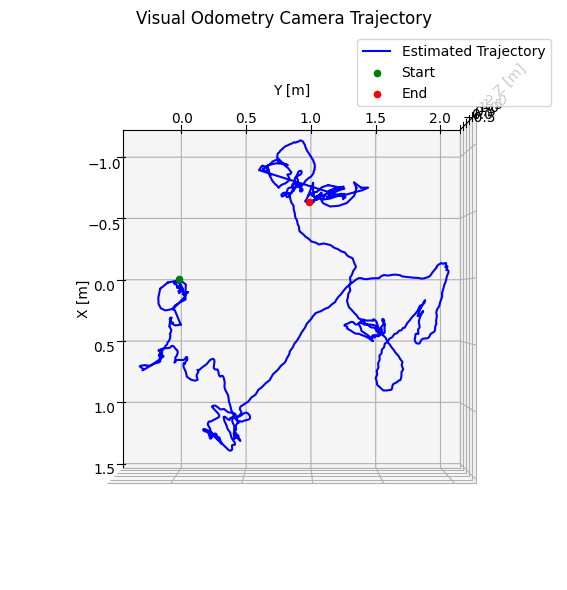

In [10]:
# Extract XYZ positions
positions = np.array([pose[:3, 3] for pose in trajectory])

#scale to meters
positions = positions / 1000  # TODO: tak, jest to dzielenie objawione w wizji

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Estimated Trajectory', color='blue')
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], color='green', label='Start')
ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], color='red', label='End')

ax.set_title("Visual Odometry Camera Trajectory")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.legend()
ax.grid()
ax.view_init(azim=0, elev=90)
plt.tight_layout()
plt.show()

Widok 3D

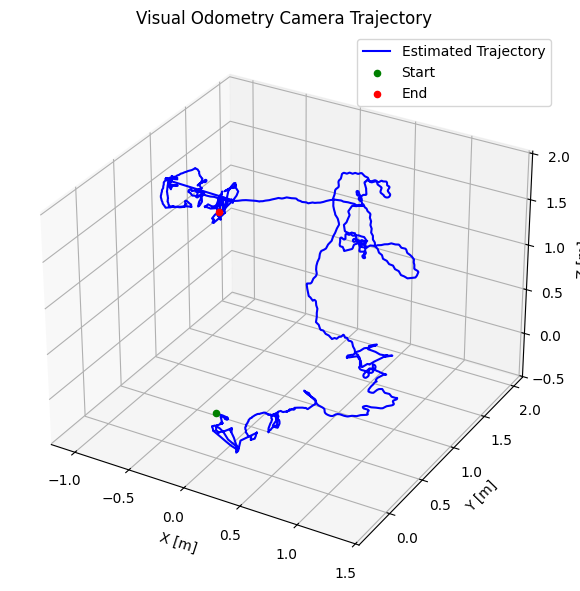

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Estimated Trajectory', color='blue')
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], color='green', label='Start')
ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], color='red', label='End')

ax.set_title("Visual Odometry Camera Trajectory")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()


Porównanie z GT

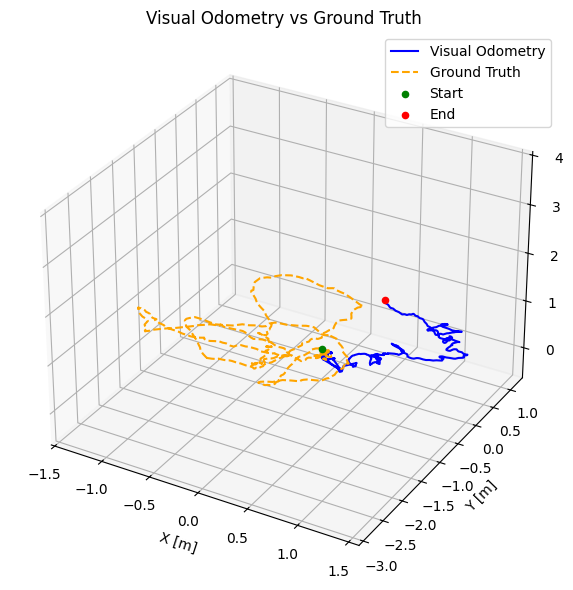

In [13]:
# ---- Load Ground Truth from TUM format file ----
gt_file = "E:/projekt zaw/projekt/falcon_indoor_flight_1_pose_evo_gt.txt"
gt_positions = []
with open(gt_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 8:
            continue
        tx, ty, tz = map(float, parts[1:4])
        gt_positions.append([tx, ty, tz])

gt_positions = np.array(gt_positions)


# ---- Match lengths if necessary ----
min_len = min(len(gt_positions), len(positions))
gt_positions = gt_positions[:min_len]
vo_positions = positions[:min_len]

# ---- Plot VO vs Ground Truth ----
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(vo_positions[:, 0], vo_positions[:, 1], vo_positions[:, 2], label='Visual Odometry', color='blue')
ax.plot(gt_positions[:, 0], gt_positions[:, 1], gt_positions[:, 2], label='Ground Truth', color='orange', linestyle='--')

ax.scatter(vo_positions[0, 0], vo_positions[0, 1], vo_positions[0, 2], color='green', label='Start')
ax.scatter(vo_positions[-1, 0], vo_positions[-1, 1], vo_positions[-1, 2], color='red', label='End')

ax.set_title("Visual Odometry vs Ground Truth")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()
